# lorapy symbol extraction

In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import os, sys
from loguru import logger
logger.remove(None)
logger.add(sys.stdout, colorize=True)

import numpy as np
from six.moves import cPickle
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt 
plt.style.use('dark_background')
%matplotlib inline

In [2]:
import lorapy

## setup 

In [3]:
_BASE_DATA_DIR = pathlib.Path('/Users/trevor/Work/1-projects/lora-processing/data')

BENCHTOP_DATA_DIR = _BASE_DATA_DIR.joinpath('lora-benchtop-recording')
OTA_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_OTA')
OUTDOOR_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_Outdoor')
DOTP_DATA_DIR = _BASE_DATA_DIR.joinpath('symbol-ref')
SYMBOL_DIR = _BASE_DATA_DIR.joinpath('lora-symbols-20k')
PREAM_WIN_DIR = _BASE_DATA_DIR.joinpath('lora-preamble-windows-20k')

# load

## preamble windows

In [4]:
loader = lorapy.load_dotp(PREAM_WIN_DIR, autoload=True)
loader.file_list

2020-04-09 17:44:06.342 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/lora-preamble-windows-20k
2020-04-09 17:44:06.349 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 93 data file(s)


[DotPFile(id=0 | name='lora_BW2_SF11_915MHz_20ksps_Att60_v0.p'),
 DotPFile(id=1 | name='lora_BW8_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=2 | name='lora_BW8_SF12_915MHz_20ksps_Att20_v0.p'),
 DotPFile(id=3 | name='lora_BW1_SF11_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=4 | name='lora_BW8_SF10_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=5 | name='lora_BW7_SF10_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=6 | name='lora_BW7_SF12_915MHz_20ksps_Att20_v0.p'),
 DotPFile(id=7 | name='lora_BW2_SF11_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=8 | name='lora_BW7_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=9 | name='lora_BW2_SF12_915MHz_20ksps_Att120_v0.p'),
 DotPFile(id=10 | name='lora_BW8_SF12_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=11 | name='lora_BW8_SF12_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=12 | name='lora_BW7_SF12_915MHz_20ksps_Att60_v0.p'),
 DotPFile(id=13 | name='lora_BW9_SF10_915MHz_20ksps_Att120_v0.p'),
 DotPFile(id=14 | name='lora_BW7_SF12_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=15 | n

## base symbol files

In [5]:
ploader = lorapy.load_dotp(DOTP_DATA_DIR)
ploader.file_list

2020-04-09 17:44:06.392 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/symbol-ref
2020-04-09 17:44:06.394 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 15 data file(s)


[DotPFile(id=0 | name='lora_BW8_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=1 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=2 | name='lora_BW7_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=3 | name='lora_BW1_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=4 | name='lora_BW8_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=5 | name='lora_BW2_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=6 | name='lora_BW1_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=7 | name='lora_BW9_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=8 | name='lora_BW7_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=9 | name='lora_BW2_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=10 | name='lora_BW2_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=11 | name='lora_BW8_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=12 | name='lora_BW7_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=13 | name='lora_BW9_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=14 | name='lora_BW1_SF11_915MHz_20ksps_Att0_v0.p')]

# process 

In [6]:
import scipy as sp
import scipy.signal as spsig

from lorapy.symbols import utils as sym_utils

## symbol correlation settings

In [83]:
_step_dict = {
    1: 100,
    2: 100,
    7: 4,
    8: 2,
    9: 1,
}

## functions

In [8]:
def _load_matching_dotp(bw: int, sf: int):
    return ploader.filter(bw=bw, sf=sf)[0]

def _convert_files(file, dotp_file):
    return file.to_signal(), dotp_file.to_signal()

def _extract_and_manual_adjust(baseline_symbol, step_dict):
    signal.extract_packets(method='slide-mean', auto_adj=False, overlap=0.7)
    signal.adjust_packets(
        force_check=True, baseline_symbol=base_symbol, 
        range_factor=10, step=step_dict[signal.stats.bw], scalar=0.6
    )
    
    return signal.packets


def _format_output_path(packet):
    _base_path = pathlib.Path('data/lora-preamble-windows-20k')
    filename = pathlib.Path(packet.stats.filename)
    out_path = _base_path.joinpath(filename.with_suffix('').with_suffix('.p'))
    
    return out_path

def _save_symbols(data, packet):
    out_path = _format_output_path(packet)
    
    with out_path.open('wb') as outfile:
        cPickle.dump(data, outfile)

        
def _extract_symbols(packet):
    packet.extract_preamble_window()
    return packet._preamble_window

def _extract_and_save_symbols(packets):
    full_array = np.vstack([
        _extract_symbols(packet)
        for packet in packets
    ])
    
    packet = packets[0]
    _save_symbols(full_array, packet)
        

## setup

In [62]:
loader.filter(bw=9, sf=10)

[DotPFile(id=8 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=14 | name='lora_BW9_SF10_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=15 | name='lora_BW9_SF10_915MHz_20ksps_Att120_v0.p'),
 DotPFile(id=63 | name='lora_BW9_SF10_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=73 | name='lora_BW9_SF10_915MHz_20ksps_Att60_v0.p')]

In [63]:
file = loader.select(73).load()
file

2020-04-09 18:12:03.582 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-09 18:12:03.712 | INFO     | lorapy.datafile._base_file:load:61 - loaded 5520000 samples from file


DotPFile(id=73 | name='lora_BW9_SF10_915MHz_20ksps_Att60_v0.p')

In [64]:
dotp_file = _load_matching_dotp(file.bw, file.sf)
dotp_file

DotPFile(id=1 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p')

In [65]:
preambles, base_symbol = _convert_files(file, dotp_file)
preambles, base_symbol

2020-04-09 18:12:09.886 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-09 18:12:09.888 | INFO     | lorapy.datafile._base_file:load:61 - loaded 399 samples from file


(BaselineSymbolSet(num symbols=1150 | BW: 9 | SF: 10 | Att: 60 | samples per symbol: 400 | packet length: 12100),
 BaselineSymbolSet(num symbols=399 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100))

In [66]:
preambles.data.shape, base_symbol.data.shape

((1150, 4800), (399,))

# convolve

## functionized

In [17]:
def _get_correlation_values(base_symbol, preamble, samp_per_sym, shift_step):
    shifts = sym_utils.generate_shifts(
        samp_per_sym, range_factor=10, step=shift_step,
    )
    
    corr_vals = sym_utils.shift_and_correlate(
        base_symbol.data, preamble, samp_per_sym, shifts,
    ) 
    
    return corr_vals

def _get_adjusted_distance(samp_per_sym, shift_step):
    distance = int(samp_per_sym // shift_step)
    distance *= 0.90 
    return distance


def _find_peaks(corr_vals, samp_per_sym, shift_step):
    adjusted_dist = _get_adjusted_distance(samp_per_sym, shift_step)
    
    peaks = spsig.find_peaks(
        corr_vals, 
        distance=adjusted_dist,
    )[0]
    
    return peaks 

def _sanity_plot(corr_vals, peaks):
    symbol_strips = [
        np.max(corr_vals) * 1.1 if idx in peaks else 0
        for idx, _ in enumerate([0] * len(corr_vals))
    ]
    
    fig, axs = plt.subplots(2)
    axs[0].plot(corr_vals)
    axs[1].plot(corr_vals)
    axs[1].plot(symbol_strips)
    plt.show()

In [84]:
samp_per_sym = preambles.stats.samp_per_sym
shift_step = _step_dict[preambles.stats.bw]

samp_per_sym, shift_step

(400, 1)

In [96]:
for preamble in preambles.data[:68]:
    pass
    
preamble

array([-3.05183457e-05-6.10366915e-05j, -3.05183457e-05-3.05183457e-05j,
       -3.05183457e-05-3.05183457e-05j, ...,
        1.06814213e-03+5.79848594e-04j, -5.49330201e-04-6.71403599e-04j,
       -3.05183457e-05+5.49330201e-04j])

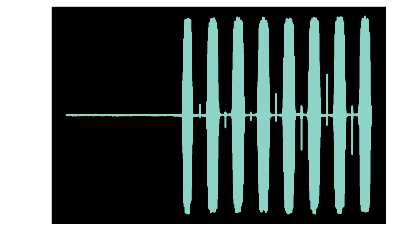

In [97]:
plt.plot(preamble)

In [113]:
np.histogram(preamble)

(array([ 188,  135,  104,  129, 1893, 1804,  109,  124,  113,  201]),
 array([-1.79447867e-02-0.00088503j, -1.43527774e-02-0.00086367j,
        -1.07607681e-02-0.00084231j, -7.16875885e-03-0.00082094j,
        -3.57674956e-03-0.00079958j,  1.52597204e-05-0.00077822j,
         3.60726900e-03-0.00075685j,  7.19927829e-03-0.00073549j,
         1.07912876e-02-0.00071413j,  1.43832969e-02-0.00069277j,
         1.79753061e-02-0.0006714j ]))

/Users/trevor/miniconda3/envs/py37-prime/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


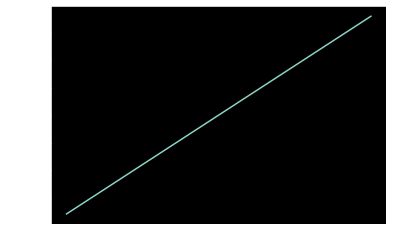

In [110]:
plt.plot(np.histogram(preamble)[1])

In [98]:
corr_vals = _get_correlation_values(base_symbol, preamble, samp_per_sym, shift_step)
corr_vals[:5]

[0.11601534371389442,
 0.03027363471910174,
 0.0827028431847779,
 0.04576037017963022,
 0.03661120535813514]

In [99]:
peaks = _find_peaks(corr_vals, samp_per_sym, shift_step)
peaks

array([ 281,  905, 1284, 1738, 2125, 2525, 2925, 3325, 3725])

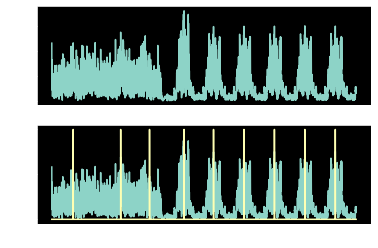

In [100]:
_sanity_plot(corr_vals, peaks)

2525

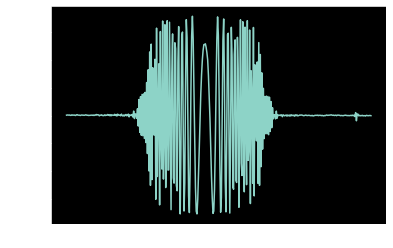

In [102]:
peak = peaks[5]
display(peak)

plt.plot(preamble[peak:peak+samp_per_sym])

/Users/trevor/miniconda3/envs/py37-prime/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


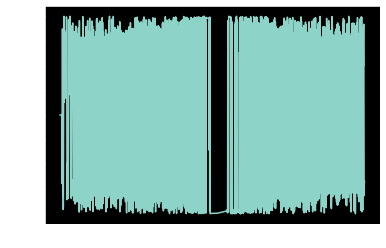

In [28]:
plt.plot(preambles.data[0, peak:peak+samp_per_sym])

## original

In [14]:
samp_per_sym = preambles.stats.samp_per_sym
shift_step = _step_dict[preambles.stats.bw]

samp_per_sym, shift_step

(1599, 4)

In [ ]:
shifts = sym_utils.generate_shifts(
    samp_per_sym, range_factor=10, step=shift_step,
)

/Users/trevor/miniconda3/envs/py37-prime/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


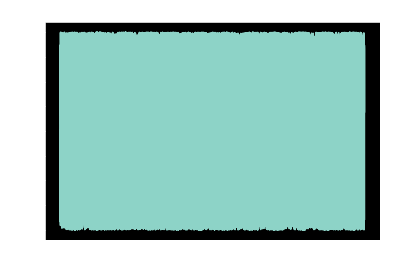

In [15]:
preambles.plot(0)

In [16]:
for preamble in preambles.data:
    break
    
preamble

array([-9.1555034e-05+0.00439464j,  3.0518346e-05+0.00442516j,
       -6.1036691e-05+0.00433361j, ...,  7.8938752e-01-0.9301687j ,
        8.2896984e-01-0.3456508j ,  1.9415772e-01-0.85350657j],
      dtype=complex64)

In [ ]:
corr_vals = sym_utils.shift_and_correlate(
    base_symbol.data, preamble, samp_per_sym, shifts,
)

plt.plot(corr_vals)

## find peaks 

In [ ]:
adjusted_dist = int(samp_per_sym // shift_step)
adjusted_dist *= 0.90

peaks = spsig.find_peaks(
    corr_vals, 
    distance=adjusted_dist,
)[0]

peaks

In [ ]:
symbol_strips = [
    np.max(corr_vals) * 1.1 if idx in peaks else 0
    for idx, _ in enumerate([0] * len(corr_vals))
]

plt.plot(corr_vals)
plt.plot(symbol_strips)

In [ ]:
symnum = 0
plt.plot(preambles.data[0, symnum:symnum+samp_per_sym])